<a href="https://colab.research.google.com/github/francesco-schinea/NAMLproject_OscarPredictions/blob/main/Oscar_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Analisi e Manipolazione Dati
import pandas as pd
import numpy as np

# Visualizzazione Dati
import matplotlib.pyplot as plt
import seaborn as sns

#JAX
import jax.numpy as jnp
import jax

In [ ]:
# Caricamento dei file
df_picture = pd.read_csv("oscardata_bestpicture.csv")
df_director = pd.read_csv("oscardata_bestdirector.csv")
df_acting = pd.read_csv("oscardata_acting.csv")

print("--- DataFrame Best Picture (Vincitore/Nominato Miglior Film) ---")
print(df_picture.shape)
print(df_picture.head())

print("\n--- DataFrame Best Director (Vincitore/Nominato Miglior Regista) ---")
print(df_director.shape)
print(df_director.head())

print("\n--- DataFrame Acting (Vincitore/Nominato Attore/Attrice) ---")
print(df_acting.shape)
print(df_acting.head())

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

# --- 1. Caricamento e Pulizia Dati ---
df_picture = pd.read_csv("oscardata_bestpicture.csv")

def preprocess_dates_and_lag(df):
    """Calcola il ritardo di rilascio."""
    df['Release_date'] = pd.to_datetime(df['Release_date'], errors='coerce')
    df['Oscar_Date'] = pd.to_datetime(df['Year'].astype(str) + '-03-01', errors='coerce')
    df['Release_Lag_Days'] = (df['Oscar_Date'] - df['Release_date']).dt.days
    if 'Release_Lag_Days' in df.columns:
        # Se il lag è negativo (uscito dopo gli Oscar), lo consideriamo 0 per la regressione
        df['Release_Lag_Days'] = df['Release_Lag_Days'].apply(lambda x: 0 if x < 0 else x)
    return df

df_picture_processed = preprocess_dates_and_lag(df_picture.copy())
df_picture_processed.dropna(subset=['Winner'], inplace=True)

drop_cols_picture = ['Film', 'Nominee', 'Category', 'Release_date', 'Oscar_Date', 'MPAA_rating', 'Year', 'Genre_filmnoir']
df_picture_clean = df_picture_processed.drop(columns=drop_cols_picture, errors='ignore')

# 2. Divisione X e Y e Split in Training/Test
Y_picture = df_picture_clean['Winner']
X_picture = df_picture_clean.drop('Winner', axis=1)

X_train_pic, X_test_pic, Y_train_pic, Y_test_pic = train_test_split(
    X_picture, Y_picture, test_size=0.2, random_state=42, stratify=Y_picture
)

# 3. Definizione del Preprocessing (Scaling e Imputazione)
numeric_features_picture = ['Rating_IMDB', 'Rating_rtaudience', 'Rating_rtcritic', 'Oscarstat_totalnoms', 'Release_Lag_Days']
binary_features_picture = [col for col in X_picture.columns if col not in numeric_features_picture]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

preprocessor_picture = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_picture),
        ('binary', binary_transformer, binary_features_picture)
    ],
    remainder='passthrough'
)

# 4. Addestramento del Modello e Estrazione Coefficienti
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_picture),
    ('classifier', LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42))
])

model_lr.fit(X_train_pic, Y_train_pic)

# 5. Estrazione Coefficienti e Predizioni (PER I GRAFICI)
Y_pred_pic = model_lr.predict(X_test_pic)

# Estrai i nomi delle feature e i coefficienti
numeric_feature_names = numeric_features_picture
binary_feature_names = model_lr['preprocessor'].named_transformers_['binary']['imputer'].get_feature_names_out(binary_features_picture).tolist()
feature_names = numeric_feature_names + binary_feature_names
coefficients = model_lr['classifier'].coef_[0]

coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficiente': coefficients
}).sort_values(by='Coefficiente', ascending=False)

print("Setup completo: il modello è addestrato e i coefficienti sono estratti.")

Setup completo: il modello è addestrato e i coefficienti sono estratti.


/tmp/ipython-input-6496885.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficiente', y='Feature', data=top_20_features, palette=colors)


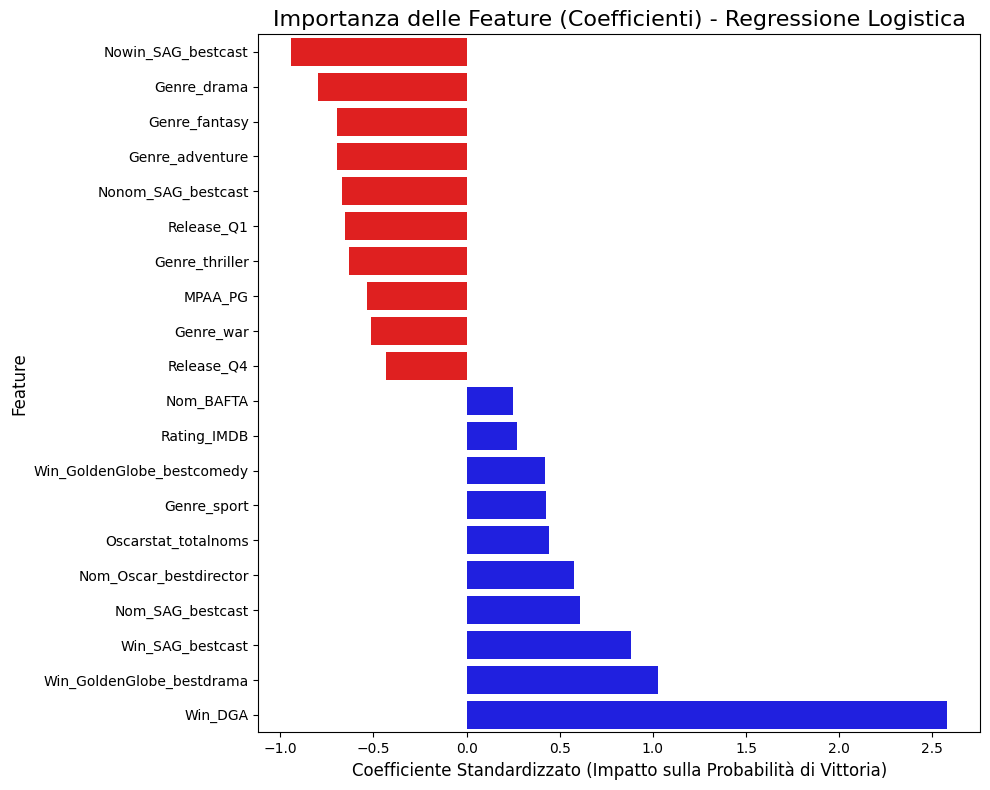

In [14]:
# Grafico 1: Importanza delle Feature (Coefficienti)
plt.figure(figsize=(10, 8))
top_10_pos = coefficients_df.head(10)
top_10_neg = coefficients_df.tail(10).sort_values(by='Coefficiente', ascending=True)
top_20_features = pd.concat([top_10_neg, top_10_pos]).sort_values(by='Coefficiente', ascending=True)

colors = ['red' if c < 0 else 'blue' for c in top_20_features['Coefficiente']]
sns.barplot(x='Coefficiente', y='Feature', data=top_20_features, palette=colors)
plt.title('Importanza delle Feature (Coefficienti) - Regressione Logistica', fontsize=16)
plt.xlabel('Coefficiente Standardizzato (Impatto sulla Probabilità di Vittoria)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('coefficienti_best_picture.png')
plt.show()

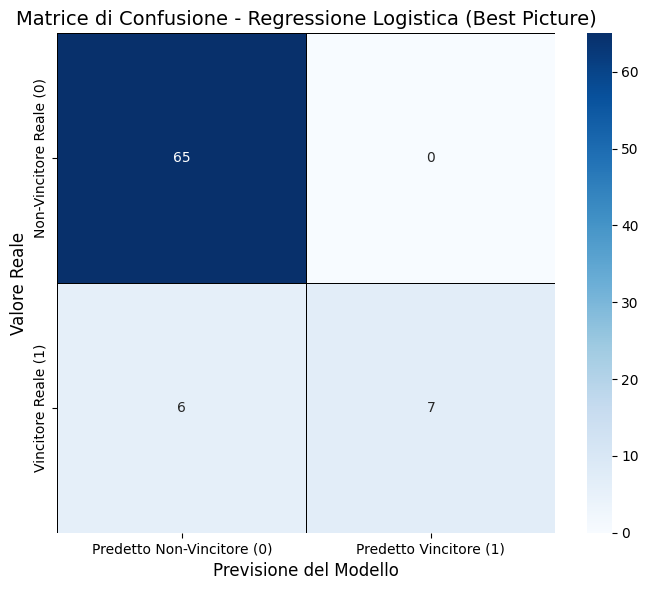

In [15]:
# Grafico 2: Matrice di Confusione
cm = confusion_matrix(Y_test_pic, Y_pred_pic)
cm_df = pd.DataFrame(cm,
                     index=['Non-Vincitore Reale (0)', 'Vincitore Reale (1)'],
                     columns=['Predetto Non-Vincitore (0)', 'Predetto Vincitore (1)'])

plt.figure(figsize=(7, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=0.5, linecolor='black')
plt.title('Matrice di Confusione - Regressione Logistica (Best Picture)', fontsize=14)
plt.xlabel('Previsione del Modello', fontsize=12)
plt.ylabel('Valore Reale', fontsize=12)
plt.tight_layout()
plt.savefig('matrice_confusione_best_picture.png')
plt.show()

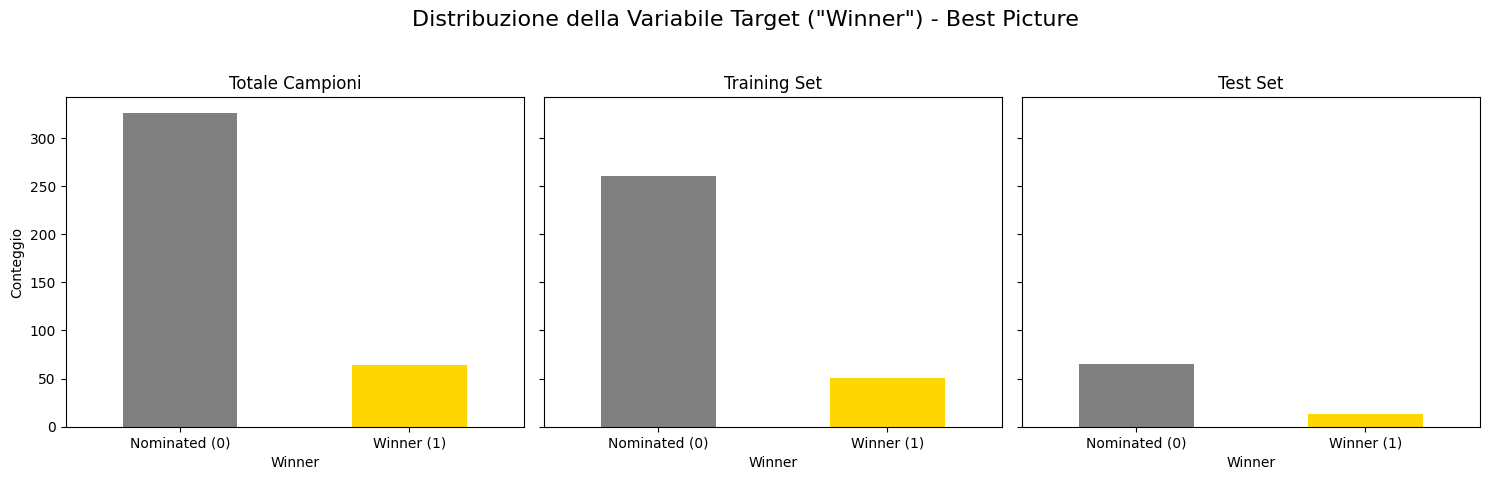

In [16]:
# Grafico 3: Bilanciamento del Target
total_counts = df_picture['Winner'].value_counts()
train_counts = Y_train_pic.value_counts()
test_counts = Y_test_pic.value_counts()

# Creazione del plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Distribuzione della Variabile Target ("Winner") - Best Picture', fontsize=16)

# Grafico 1: Totale
total_counts.plot(kind='bar', ax=axes[0], color=['gray', 'gold'])
axes[0].set_title('Totale Campioni')
axes[0].set_xticks([0, 1], ['Nominated (0)', 'Winner (1)'], rotation=0)
axes[0].set_ylabel('Conteggio')

# Grafico 2: Training Set
train_counts.plot(kind='bar', ax=axes[1], color=['gray', 'gold'])
axes[1].set_title('Training Set')
axes[1].set_xticks([0, 1], ['Nominated (0)', 'Winner (1)'], rotation=0)

# Grafico 3: Test Set
test_counts.plot(kind='bar', ax=axes[2], color=['gray', 'gold'])
axes[2].set_title('Test Set')
axes[2].set_xticks([0, 1], ['Nominated (0)', 'Winner (1)'], rotation=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('bilanciamento_target_best_picture.png')
plt.show()